# Quanvolutional Neural Network

This notebook is based on the use of [Quanvolutional Neural Networks](https://arxiv.org/abs/1904.04767) for the image classification task. 

It uses a basic quantum circuit with random layers , in order to form the Quanvolutional layer. The training images, have to be first transformed using this layer, before being fed into the network. This process is particularly time consuming to be carried out on a classical CPU.

The quanv layer process images in fields of size of 4X4 and stride 4, in order to capture spatial information, along with making sure the computation does not become too expensive.

The result to this is then fed into a classical Neural network, to generate outputs. The classical model is also fed with non processed output to later coampare the results.

The results are primarily evaluated on the basis of F1 score, rather than accuracy due to class imbalance. The F1 score gives better idea about the false negatives, and false positives that the model genrates. Escpecially, the False Negatives(that is the model misclassifies 1 as 0, or defective as non defective), are undesirable in production monitoring, as we must make sure that the defects are successfully detected.

In [1]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.4 MB/s eta 0:00:00


# Data Loading

Loading the data from the csv files

In [2]:
import os
import json
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

base_dir = '/kaggle/input/tig-aluminium-5083/al5083'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_json_path = os.path.join(train_dir, 'train.json')

with open(train_json_path, 'r') as f:
    train_data = json.load(f)


2024-08-08 12:30:15.442310: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 12:30:15.442487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 12:30:15.606684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Test data Loading

Loading the test data for inference later on

In [3]:

test_json_path = os.path.join(test_dir, 'test.json')

with open(test_json_path, 'r') as f:
    test_data = json.load(f)

def load_and_preprocess_image(image_path, img_size=(64, 64)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize to [0, 1]
    img = img.flatten()  # Flatten the image to a 1D array
    return img

image_paths = []
labels = []
for image_path, label in train_data.items():
    if label in [0, 1,2,3,4,5]:  
        full_image_path = os.path.join(train_dir, image_path)
        if os.path.exists(full_image_path): 
            image_paths.append(full_image_path)
            if label in [2,3,4,5]:
                labels.append(1)
            else:
                labels.append(label)



# Training Data Loading

In [4]:
def load_and_preprocess_image(image_path,image_size=(64,64)):
    img = tf.keras.preprocessing.image.load_img(image_path,target_size=image_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    return img

image_paths = []
labels = []
for image_path, label in train_data.items():
    if label in [0, 1,2,3,4,5]:  
        full_image_path = os.path.join(train_dir, image_path)
        if os.path.exists(full_image_path): 
            image_paths.append(full_image_path)
            if label in [2,3,4,5]:
                labels.append(1)
            else:
                labels.append(label)

# Preprocessing using Quonvolution

In [5]:
images=np.array([load_and_preprocess_image(img_path) for img_path in image_paths])
labels=np.array(labels)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

In [7]:
n_epochs = 10  
n_train = X_train.shape[0]   
n_test = X_val.shape[0]   
SAVE_PATH = "kaggle/quanvolution/"  # Data saving folder
PREPROCESS =False       # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)    
tf.random.set_seed(0)   

In [8]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [9]:
import pennylane as qml
import numpy as np

n_qubits = 16
n_layers = 3
dev = qml.device("lightning.qubit", wires=n_qubits)# Using lightning to speed up the process
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubits))

@qml.qnode(dev)
def circuit(phi):
    for j in range(n_qubits):
        qml.RY(np.pi * phi[j], wires=j)
    qml.templates.layers.RandomLayers(rand_params, wires=list(range(n_qubits)))
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

**This part is our Quanvolutional layer, the heart of this approach**

In [10]:
import numpy as np

def quanv(image):
    out = np.zeros((16, 16, 4)) 

    # Loop over the coordinates of the top-left pixel of 4x4 squares with stride 4
    for j in range(0, 61, 4):
        for k in range(0, 61, 4):
            if j + 3 < 64 and k + 3 < 64:
                # Processing a squared 4x4 region of the image with a quantum circuit
                q_results = circuit(
                    [
                        image[j, k, 0],
                        image[j, k + 1, 0],
                        image[j, k + 2, 0],
                        image[j, k + 3, 0],
                        image[j + 1, k, 0],
                        image[j + 1, k + 1, 0],
                        image[j + 1, k + 2, 0],
                        image[j + 1, k + 3, 0],
                        image[j + 2, k, 0],
                        image[j + 2, k + 1, 0],
                        image[j + 2, k + 2, 0],
                        image[j + 2, k + 3, 0],
                        image[j + 3, k, 0],
                        image[j + 3, k + 1, 0],
                        image[j + 3, k + 2, 0],
                        image[j + 3, k + 3, 0]
                    ]
                )
                # Assigning expectation values to different channels of the output pixel (j/4, k/4)
                for c in range(4):
                    out[j // 4, k // 4, c] = q_results[c]
    return out


In [11]:
from pennylane import numpy as np

Here I proceesed images in the batches of 2000, due to contraints in computational power

In [12]:
"""train_images=X_train[start_index:end_index]
test_images=X_val[:2000]
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)
train_labels=y_train[start_index:end_index]
test_labels=y_val[:2000]"""

'train_images=X_train[6000:8000]\ntest_images=X_val[:2000]\ntrain_images = np.array(train_images[..., tf.newaxis], requires_grad=False)\ntest_images = np.array(test_images[..., tf.newaxis], requires_grad=False)\ntrain_labels=y_train[6000:8000]\ntest_labels=y_val[:2000]'

In [13]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1,end_index-start_index))
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)
    np.save("q_train_images.npy", q_train_images)
    np.save("Train_labels",y_train)
    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1,2000))
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)
    np.save("Train_labels",y_train)
    np.save("test_labels",y_val)


# Loading pre-processed images
q_train_images = np.load("/kaggle/input/0-2000-train-valid/q_train_images.npy")
q_test_images = np.load("/kaggle/input/0-2000-train-valid/q_test_images.npy")
train_2_4=np.load("/kaggle/input/2000-4000/q_train_images.npy")
train_4_6=np.load("/kaggle/input/4000-6000/q_train_images.npy")
train_6_8=np.load("/kaggle/input/6000-8000/q_train_images.npy")

train_labels=np.load("/kaggle/input/0-2000-train-valid/Train_labels.npy")
train_labels24=np.load("/kaggle/input/2000-4000/Train_labels.npy")
train_labels46=np.load("/kaggle/input/4000-6000/Train_labels.npy")
train_labels68=np.load("/kaggle/input/6000-8000/Train_labels.npy")
test_labels=np.load("/kaggle/input/0-2000-train-valid/test_labels.npy")[:2000]

In [14]:
q_train_images = np.concatenate((q_train_images, train_2_4, train_4_6, train_6_8), axis=0)
q_train_labels = np.concatenate((train_labels, train_labels24, train_labels46, train_labels68), axis=0)
q_train_labels=train_labels[:8000]

In [15]:
# Verifying the shapes
print("Combined train images shape:", q_train_images.shape)
print("Combined train labels shape:", q_train_labels.shape)

Combined train images shape: (8000, 16, 16, 4)
Combined train labels shape: (8000,)


The classical Model used here is very basic one, with just an input layer,and the output layer.

In [16]:
def ClassicalModel():
    model = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(16, 16, 4)),
        keras.layers.Flatten(),
        keras.layers.Dense(2, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

**Training model with Quantum Model**

In [17]:
q_model = ClassicalModel()

q_history = q_model.fit(
    q_train_images,
    q_train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=16,
    epochs=n_epochs,
    verbose=2,
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
500/500 - 2s - 4ms/step - accuracy: 0.8511 - loss: 0.3616 - val_accuracy: 0.8760 - val_loss: 0.2986
Epoch 2/10
500/500 - 1s - 2ms/step - accuracy: 0.8972 - loss: 0.2658 - val_accuracy: 0.8905 - val_loss: 0.2614
Epoch 3/10
500/500 - 1s - 2ms/step - accuracy: 0.9084 - loss: 0.2350 - val_accuracy: 0.9020 - val_loss: 0.2356
Epoch 4/10
500/500 - 1s - 2ms/step - accuracy: 0.9193 - loss: 0.2139 - val_accuracy: 0.9115 - val_loss: 0.2156
Epoch 5/10
500/500 - 1s - 2ms/step - accuracy: 0.9283 - loss: 0.1977 - val_accuracy: 0.9190 - val_loss: 0.1997
Epoch 6/10
500/500 - 1s - 2ms/step - accuracy: 0.9346 - loss: 0.1848 - val_accuracy: 0.9275 - val_loss: 0.1869
Epoch 7/10
500/500 - 1s - 2ms/step - accuracy: 0.9380 - loss: 0.1741 - val_accuracy: 0.9315 - val_loss: 0.1764
Epoch 8/10
500/500 - 1s - 2ms/step - accuracy: 0.9419 - loss: 0.1651 - val_accuracy: 0.9360 - val_loss: 0.1676
Epoch 9/10
500/500 - 1s - 2ms/step - accuracy: 0.9450 - loss: 0.1574 - val_accuracy: 0.9385 - val_loss: 0.1600
E

**Training model with Classical data**

In [18]:
def ClassicalModel():
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(2, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [19]:
# To understand the effect of using Quantum Convolution, I am also training the same model on classical data
c_train_images=X_train[:8000]
c_train_labels=y_train[:8000]
c_test_images=X_val[:2000]
c_test_labels=y_val[:2000]
c_train_images = np.array(c_train_images[..., tf.newaxis], requires_grad=False)
c_test_images = np.array(c_test_images[..., tf.newaxis], requires_grad=False)
class_model = ClassicalModel()
class_history = class_model.fit(
    c_train_images,
    c_train_labels,
    validation_data=(c_test_images, c_test_labels),
    batch_size=16,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/10
500/500 - 3s - 6ms/step - accuracy: 0.8159 - loss: 0.3946 - val_accuracy: 0.8615 - val_loss: 0.2967
Epoch 2/10
500/500 - 2s - 3ms/step - accuracy: 0.8813 - loss: 0.2799 - val_accuracy: 0.8940 - val_loss: 0.2486
Epoch 3/10
500/500 - 2s - 3ms/step - accuracy: 0.9036 - loss: 0.2350 - val_accuracy: 0.9115 - val_loss: 0.2131
Epoch 4/10
500/500 - 2s - 5ms/step - accuracy: 0.9180 - loss: 0.2050 - val_accuracy: 0.9230 - val_loss: 0.1850
Epoch 5/10
500/500 - 2s - 3ms/step - accuracy: 0.9264 - loss: 0.1834 - val_accuracy: 0.9340 - val_loss: 0.1621
Epoch 6/10
500/500 - 2s - 3ms/step - accuracy: 0.9348 - loss: 0.1666 - val_accuracy: 0.9480 - val_loss: 0.1430
Epoch 7/10
500/500 - 2s - 3ms/step - accuracy: 0.9411 - loss: 0.1530 - val_accuracy: 0.9530 - val_loss: 0.1272
Epoch 8/10
500/500 - 2s - 3ms/step - accuracy: 0.9455 - loss: 0.1417 - val_accuracy: 0.9565 - val_loss: 0.1138
Epoch 9/10
500/500 - 2s - 3ms/step - accuracy: 0.9496 - loss: 0.1323 - val_accuracy: 0.9600 - val_loss: 0.1021
E

As we can see the accuracy obtained on the validation dataset is more without quantum layer, than with it. 


**Comparing the results**

/tmp/ipykernel_18/554733545.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


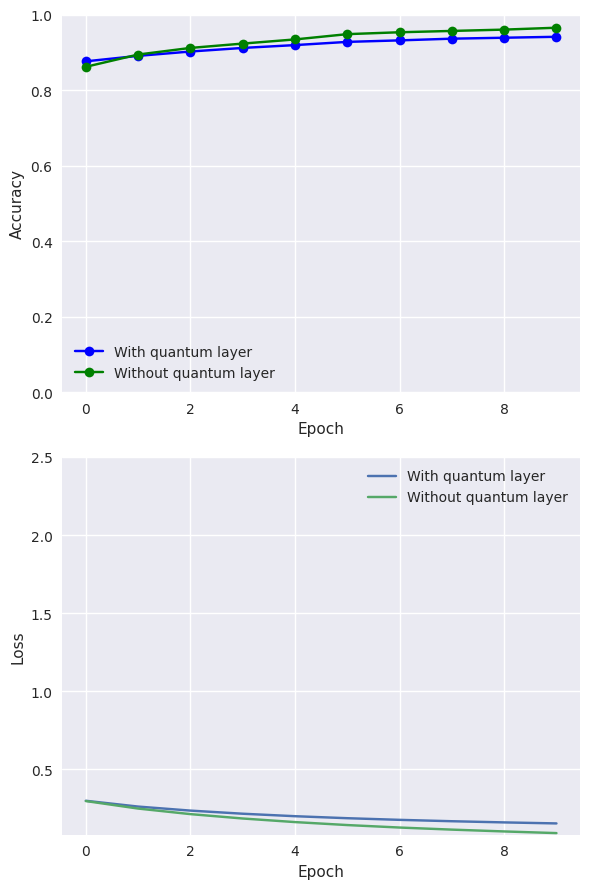

In [20]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(class_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], label="With quantum layer")
ax2.plot(class_history.history["val_loss"], label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

# Evaluating on Validation set

**1) Quantum Model**

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/tmp/ipykernel_18/1849215188.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


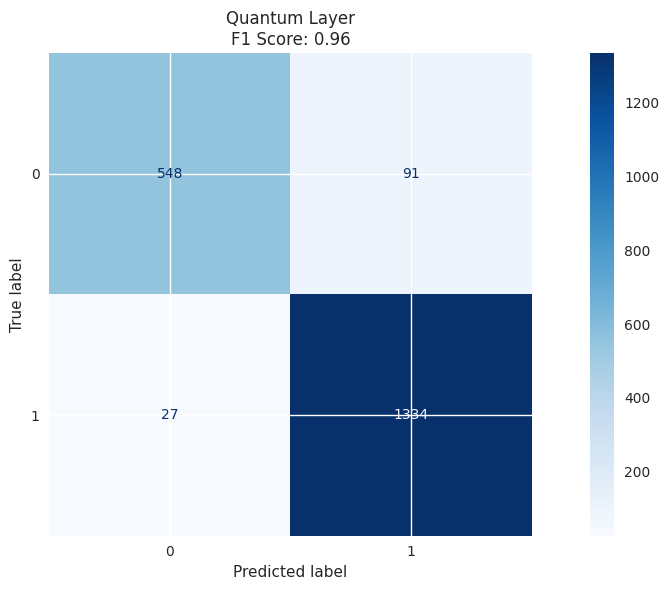

In [21]:
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
q_pred_labels = np.argmax(q_model.predict(q_test_images), axis=1)
q_conf_matrix = confusion_matrix(test_labels, q_pred_labels)
q_f1 = f1_score(test_labels, q_pred_labels)
plt.style.use("seaborn")
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
ConfusionMatrixDisplay(q_conf_matrix).plot(ax=axes, cmap='Blues')
axes.set_title(f'Quantum Layer\nF1 Score: {q_f1:.2f}')
plt.tight_layout()
plt.show()

The accuracy I obtained for Validation is 94% and F1 score of 0.96 , which is much more than what I obtained when I was using PCA and neural networks and considerably more training data. Now comparing it with purely classical approach.

**2) Classical Model**

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/tmp/ipykernel_18/1358341245.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


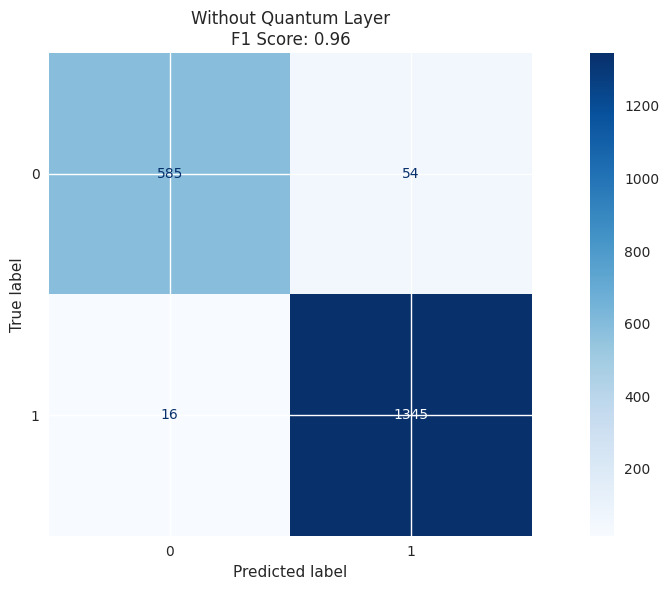

In [22]:
c_pred_labels = np.argmax(class_model.predict(c_test_images), axis=1)
c_conf_matrix = confusion_matrix(c_test_labels, c_pred_labels)
q_f1 = f1_score(c_test_labels, q_pred_labels)
plt.style.use("seaborn")
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
ConfusionMatrixDisplay(c_conf_matrix).plot(ax=axes, cmap='Blues')
axes.set_title(f'Without Quantum Layer\nF1 Score: {q_f1:.2f}')
plt.tight_layout()
plt.show()

# Using a classically complex model

Here I am using a calssical model with more hiden layers,and dropout to prevent overfitting, if any.

**1) Quantum Layer**

In [23]:
def complexModel():
    model = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(16, 16, 4)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.2), 
        keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [24]:
qc_model = complexModel()

qc_history = qc_model.fit(
    q_train_images,
    q_train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=16,
    epochs=n_epochs,
    verbose=2,
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
500/500 - 3s - 7ms/step - accuracy: 0.8491 - loss: 0.3489 - val_accuracy: 0.8930 - val_loss: 0.2442
Epoch 2/10
500/500 - 2s - 4ms/step - accuracy: 0.8942 - loss: 0.2543 - val_accuracy: 0.8985 - val_loss: 0.2105
Epoch 3/10
500/500 - 2s - 4ms/step - accuracy: 0.8970 - loss: 0.2282 - val_accuracy: 0.8655 - val_loss: 0.2943
Epoch 4/10
500/500 - 2s - 4ms/step - accuracy: 0.9239 - loss: 0.1843 - val_accuracy: 0.9520 - val_loss: 0.1257
Epoch 5/10
500/500 - 2s - 4ms/step - accuracy: 0.9195 - loss: 0.1797 - val_accuracy: 0.9435 - val_loss: 0.1576
Epoch 6/10
500/500 - 2s - 4ms/step - accuracy: 0.9251 - loss: 0.1743 - val_accuracy: 0.9440 - val_loss: 0.1493
Epoch 7/10
500/500 - 2s - 4ms/step - accuracy: 0.8997 - loss: 0.2145 - val_accuracy: 0.8695 - val_loss: 0.2627
Epoch 8/10
500/500 - 2s - 4ms/step - accuracy: 0.9007 - loss: 0.2005 - val_accuracy: 0.9440 - val_loss: 0.1247
Epoch 9/10
500/500 - 2s - 3ms/step - accuracy: 0.9079 - loss: 0.1785 - val_accuracy: 0.9215 - val_loss: 0.1665
E

**2) Classical Model**

In [25]:
def complexModel():
    model = keras.models.Sequential([
        
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.2), 
        keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [26]:
cclass_model =complexModel()
cclass_history = cclass_model.fit(
    c_train_images,
    c_train_labels,
    validation_data=(c_test_images, c_test_labels),
    batch_size=16,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/10
500/500 - 8s - 16ms/step - accuracy: 0.6781 - loss: 0.5851 - val_accuracy: 0.7450 - val_loss: 0.4393
Epoch 2/10
500/500 - 6s - 12ms/step - accuracy: 0.7523 - loss: 0.4403 - val_accuracy: 0.8720 - val_loss: 0.3288
Epoch 3/10
500/500 - 6s - 11ms/step - accuracy: 0.7546 - loss: 0.4274 - val_accuracy: 0.8585 - val_loss: 0.3285
Epoch 4/10
500/500 - 6s - 11ms/step - accuracy: 0.7564 - loss: 0.4183 - val_accuracy: 0.8755 - val_loss: 0.3046
Epoch 5/10
500/500 - 6s - 11ms/step - accuracy: 0.7560 - loss: 0.4181 - val_accuracy: 0.8745 - val_loss: 0.3096
Epoch 6/10
500/500 - 5s - 11ms/step - accuracy: 0.7666 - loss: 0.4082 - val_accuracy: 0.8800 - val_loss: 0.2974
Epoch 7/10
500/500 - 6s - 12ms/step - accuracy: 0.7621 - loss: 0.4140 - val_accuracy: 0.8845 - val_loss: 0.2835
Epoch 8/10
500/500 - 6s - 12ms/step - accuracy: 0.7766 - loss: 0.3916 - val_accuracy: 0.8980 - val_loss: 0.2723
Epoch 9/10
500/500 - 6s - 11ms/step - accuracy: 0.7719 - loss: 0.3971 - val_accuracy: 0.8960 - val_loss:

This time however, the validation accuracy for the classical input is considerably less than the one with quantum processed input

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/tmp/ipykernel_18/3079895505.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


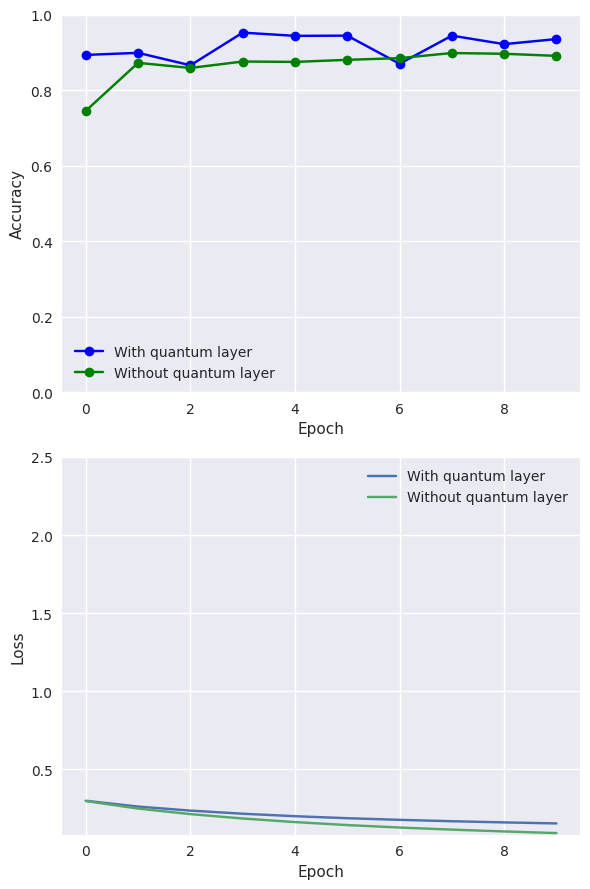

In [27]:
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
q_pred_labels = np.argmax(qc_model.predict(q_test_images), axis=1)
q_conf_matrix = confusion_matrix(test_labels, q_pred_labels)
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(qc_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(cclass_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], label="With quantum layer")
ax2.plot(class_history.history["val_loss"], label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

# Quanvolutional Inference

Loading the test data to evaluate models and generate predictions

In [28]:
with open(test_json_path, 'r') as f:
    test_data = json.load(f)

def load_and_preprocess_image(image_path, img_size=(64, 64)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  
    return img

image_paths = []
labels = []
for image_path, label in test_data.items():
    if label in [0, 1,2,3,4,5]:  
        full_image_path = os.path.join(test_dir, image_path)
        if os.path.exists(full_image_path):  
            image_paths.append(full_image_path)
            if label in [2,3,4,5]:
                labels.append(1)
            else:
                labels.append(label)

images = np.array([load_and_preprocess_image(img_path) for img_path in image_paths])
labels = np.array(labels)
X_test = images
y_test=labels

In [29]:
print(len(y_test))

6588


Since, the pre processing of images takes too much time, I am using a preprocessed datasets, of about 1200 images

In [30]:
"""test_images=X_test[start_index:end_index]
from collections import Counter
print(Counter(y_test[start_index:end_index]))"""

#This is the code I used for quanvloution preprocessing, similar to the one above
"""q_test_images = []
print("\nQuantum pre-processing of test images:")
for idx, img in enumerate(test_images):
    print("{}/{}        ".format(idx + 1,end_index-start_index),end="\r")
    q_test_images.append(quanv(img))"""


'q_test_images = []\nprint("\nQuantum pre-processing of test images:")\nfor idx, img in enumerate(test_images):\n    print("{}/{}        ".format(idx + 1,500),end="\r")\n    q_test_images.append(quanv(img))'

In [31]:
# This code is used to save the processed images
"""q_test_images = np.asarray(q_test_images)
np.save("q_testing_images.npy", q_test_images)
"""

'q_test_images = np.asarray(q_test_images)\nnp.save("q_testing_images.npy", q_test_images)\n'

In [32]:
# Here I will load my preprocessed data
q_test1 = np.load("/kaggle/input/test-data/100.npy")
q_test2 = np.load("/kaggle/input/test-data/3000-3300.npy")
q_test3=np.load("/kaggle/input/test-data/500-1000.npy")
q_test4=np.load("/kaggle/input/test-data/6200-6500.npy")
test_labels=np.concatenate((y_test[:100],y_test[3000:3300],y_test[500:1000],y_test[6200:6500]),axis=0)
q_test_images = np.concatenate((q_test1,q_test2,q_test3,q_test4),axis=0)


# Evaluating the basic models on the test data

In [33]:
from sklearn.metrics import accuracy_score
def evaluate(model,test_image):
    pred_labels = np.argmax(model.predict(test_image), axis=1)
    q_conf_matrix = confusion_matrix(test_labels, pred_labels)
    accuracy = accuracy_score(test_labels,pred_labels)
    print(f"Accuracy: {accuracy:.4f}")
    f1 = f1_score(test_labels, pred_labels)
    print("F1 Score is:",f1)
    plt.style.use("seaborn")
    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    ConfusionMatrixDisplay(q_conf_matrix).plot(ax=axes, cmap='Blues')
    plt.tight_layout()
    plt.show()

**1) Quantum version**

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.9258
F1 Score is: 0.9593792788680968


/tmp/ipykernel_18/4223525409.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


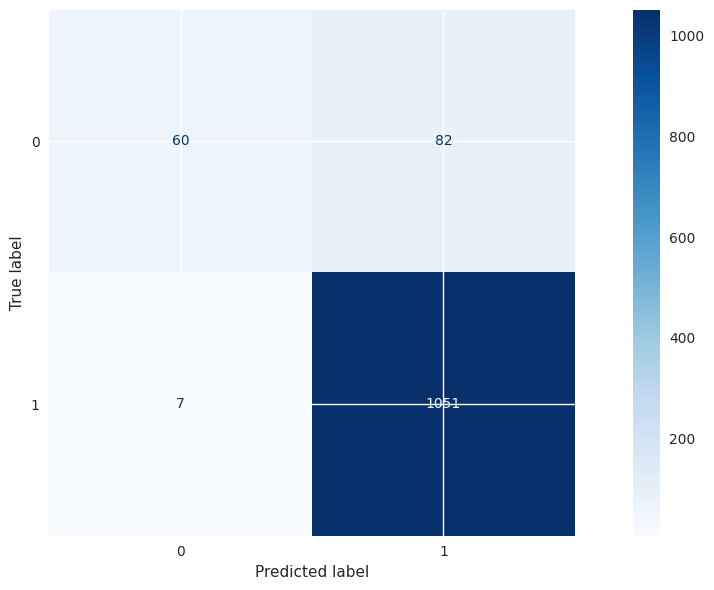

In [34]:
evaluate(q_model,q_test_images)

**2)Classical model**

In [35]:
c_test=np.concatenate((X_test[:100],X_test[3000:3300],X_test[500:1000],X_test[6200:6500]),axis=0)
c_test = np.array(c_test[..., tf.newaxis], requires_grad=False)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9183
F1 Score is: 0.9536423841059604


/tmp/ipykernel_18/4223525409.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


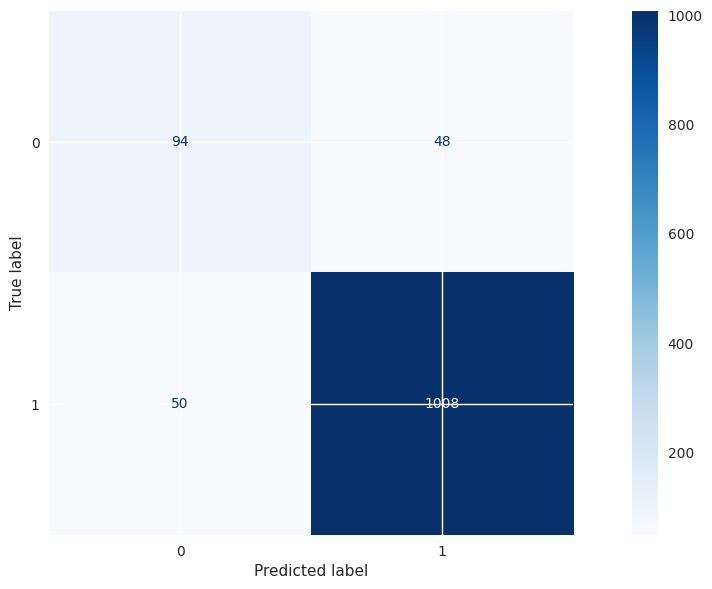

In [36]:
evaluate(class_model,c_test)

On evaluating, we find the Quantum Model actaully performs a little better on the test set,as comapred to the classical model. The accuracy and the F1 score obtained are both better for the quantum model, when we comapre it to the classical model. Also the model with quantum input, has better recall, that is it is better at detecting defects.

# Evaluating the Complex Model results 

**1) Quantum Model**

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8958
F1 Score is: 0.9418874941887495


/tmp/ipykernel_18/4223525409.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


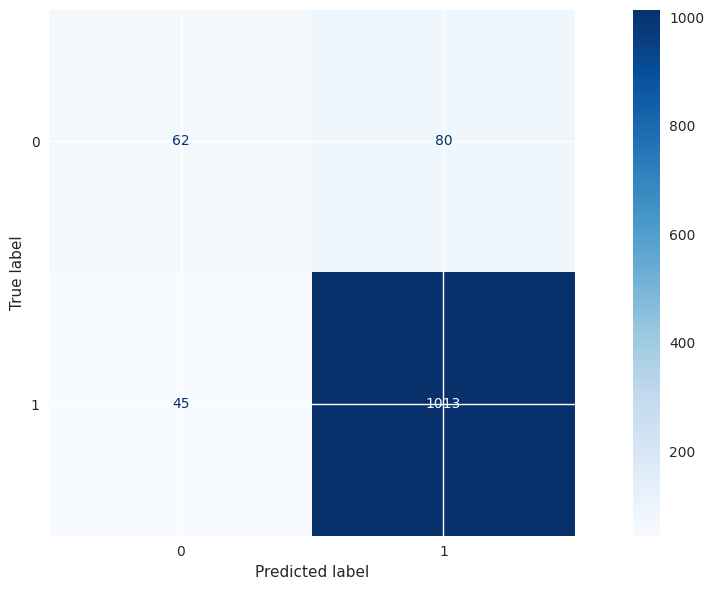

In [37]:
evaluate(qc_model,q_test_images)

**2) Classical Model**

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7233
F1 Score is: 0.8139013452914797


/tmp/ipykernel_18/4223525409.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


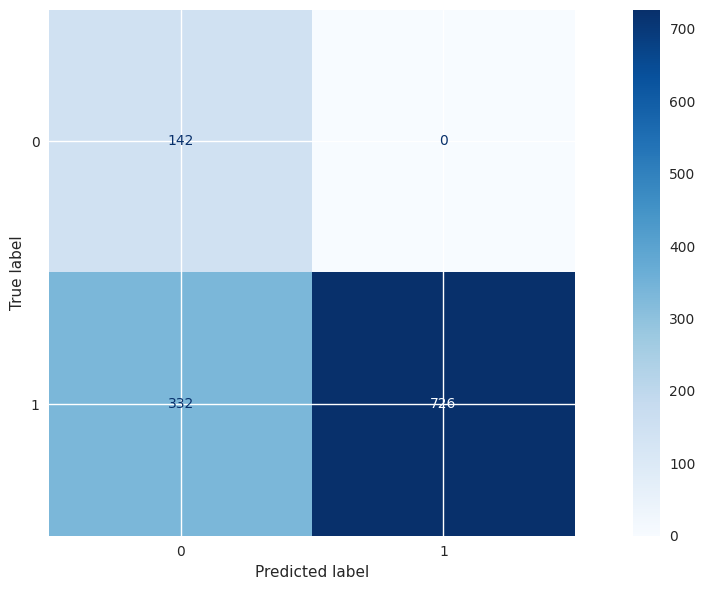

In [38]:
evaluate(cclass_model,c_test)

Again the model with quantum layer genralises better to the test dataset. Both the F1 socre and the accuracy is considerably better for the model with input images processed through quantum preprocessing. The F1 score being 0.94 as comapared to 0.81 in case of classical input. And as evident from the markdown cells, the quantum processed images took less tiem to be trained upon.

# Conclusion

As we noticed the quantum processing does add advantge to our model, and gives potentially better results. While the image has to be processed by the quantum layer before being fed into the model, and that can be time consuming, it can be reduced by actually using a quantum computer for this purpose, and further enhancements in technology. Irrespective of the difference between the scores of the predictions, we find that the Quantum processed images have a better recall value.